In [81]:
!pip install scikit-surprise

In [134]:
import json
import ast
import seaborn as sns
import numpy as np
import pandas as pd
from time import time
from surprise import Reader, Dataset, SVD

In [114]:
#read and clean json
def json_parser(filename):
    return ast.literal_eval(open(filename,'r').read().replace("\n",','))

def save_json(fname,data):
    '''
    fname - file name (str)
    data - the json data to be stored
    '''
    with open(fname, 'w') as outfile:
        outfile.write(json.dumps(data))

        
def get_user_dataframe(data):
    df = pd.DataFrame(data)
    df['playtimes'] = df['items'].apply(lambda games: [game['playtime_forever'] for game in games])
    df.drop(columns = ['items'],inplace=True)
    return df


def get_play_times(data):
    r = []
    for user in data:
        gt = []
        for game in user['items']:
            gt.append(game['playtime_forever'])
        r.append(gt)
    return r

def get_player_play_times_transformed(data,p):
    '''
    p - player number (index of data)
    '''
    return np.log(np.array(i['playtime_forever'] for i in data[p]['items'])+1)

def get_all_da_games(data):
    dict_ = {}
    for user in data:
        for game in user['items']:
            dict_[game['item_id']] = game['item_name']
    return dict_

def get_all_da_times(data):
    r = []
    for user in data:
        for game in user['items']:
            r.append(
                {'user':user['user_id'],
                 'game':game['item_id'],
                 'time_f':game['playtime_forever']}
            )
    return pd.DataFrame(r)

def transform_playtime_data(data):
    return data.groupby('user').time_f.transform(lambda x: np.log(x+1) / np.log(x.max()+1))
    

## Warning: The cell below takes 22 MINUTES!!!

In [3]:
start = time()
d = json_parser('australian_users_items.json')
print(time()-start)

1319.8635227680206


In [15]:
help(json.loads)

Help on function loads in module json:

loads(s, *, encoding=None, cls=None, object_hook=None, parse_float=None, parse_int=None, parse_constant=None, object_pairs_hook=None, **kw)
    Deserialize ``s`` (a ``str``, ``bytes`` or ``bytearray`` instance
    containing a JSON document) to a Python object.
    
    ``object_hook`` is an optional function that will be called with the
    result of any object literal decode (a ``dict``). The return value of
    ``object_hook`` will be used instead of the ``dict``. This feature
    can be used to implement custom decoders (e.g. JSON-RPC class hinting).
    
    ``object_pairs_hook`` is an optional function that will be called with the
    result of any object literal decoded with an ordered list of pairs.  The
    return value of ``object_pairs_hook`` will be used instead of the ``dict``.
    This feature can be used to implement custom decoders that rely on the
    order that the key and value pairs are decoded (for example,
    collections.Or

In [13]:
d[0]

{'user_id': '76561197970982479',
 'items_count': 277,
 'steam_id': '76561197970982479',
 'user_url': 'http://steamcommunity.com/profiles/76561197970982479',
 'items': [{'item_id': '10',
   'item_name': 'Counter-Strike',
   'playtime_forever': 6,
   'playtime_2weeks': 0},
  {'item_id': '20',
   'item_name': 'Team Fortress Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '30',
   'item_name': 'Day of Defeat',
   'playtime_forever': 7,
   'playtime_2weeks': 0},
  {'item_id': '40',
   'item_name': 'Deathmatch Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '50',
   'item_name': 'Half-Life: Opposing Force',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '60',
   'item_name': 'Ricochet',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '70',
   'item_name': 'Half-Life',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '130',
   'item_name': 'Half-Life: Blue Shift',
   'playtime_forever

In [20]:
#players
len(d)

88310

In [25]:
player_one_playtimes = [i['playtime_forever'] for i in d[0]['items']]

In [31]:
np.percentile(player_one_playtimes, np.array([0,25,50,75,100]))

array([    0.,     0.,   101.,   594., 23532.])

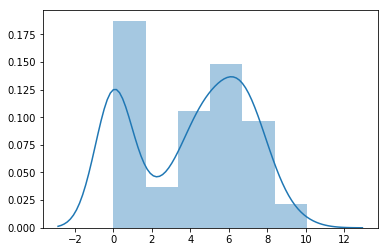

In [37]:
sns.distplot(np.log(np.array(player_one_playtimes)+1))

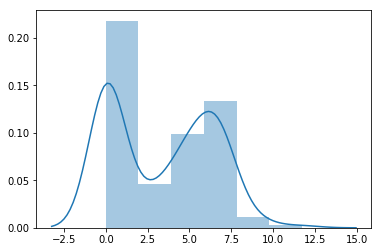

In [43]:
sns.distplot(np.log(np.array(get_player_play_times(d,1000))+1))

In [ ]:
#games per user
sns.distplot([len(i['items']) for i in d if len(i['items']) < 200])

In [35]:
np.mean([i['items_count'] for i in d])

58.353629260559394

In [51]:
start = time()
games = get_all_da_games(d)
print(time() - start)

21.53643274307251


In [95]:
g = pd.DataFrame(games,index=[0]).T.reset_index()
g.columns = ['id','name']
g.sort_values('id').reset_index(drop=True,inplace=True)

In [129]:
g.shape

(10978, 2)

In [96]:
g.head()

,id,name
0,10,Counter-Strike
1,20,Team Fortress Classic
2,30,Day of Defeat
3,40,Deathmatch Classic
4,50,Half-Life: Opposing Force


In [97]:
#save CSV
g.to_csv('all_games.csv')

#### All playtimes

In [86]:
start = time()
p = get_all_da_times(d)
print(time()-start)

24.368303060531616


In [98]:
p.head()

,game,time_f,user
0,10,6,76561197970982479
1,20,0,76561197970982479
2,30,7,76561197970982479
3,40,0,76561197970982479
4,50,0,76561197970982479


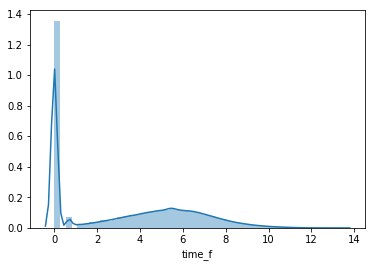

In [91]:
sns.distplot(np.log(p.time_f+1))

In [115]:
start = time()
p['rating'] = transform_playtime_data(p)
print(time()-start)

148.11099696159363


In [117]:
p = p[[
    'user',
    'game',
    'time_f',
    'rating'
]]

In [118]:
p.head(10)

,user,game,time_f,rating
0,76561197970982479,10,6,0.193312
1,76561197970982479,20,0,0.000000
2,76561197970982479,30,7,0.206577
3,76561197970982479,40,0,0.000000
4,76561197970982479,50,0,0.000000
5,76561197970982479,60,0,0.000000
6,76561197970982479,70,0,0.000000
7,76561197970982479,130,0,0.000000
8,76561197970982479,300,4733,0.840691
9,76561197970982479,240,1853,0.747564


In [119]:
p.to_csv('user_ratings.csv')

In [121]:
# 5 million rows
p.shape

(5153209, 4)

In [122]:
p.dropna().shape

(5148800, 4)

In [125]:
p.dropna(inplace=True)

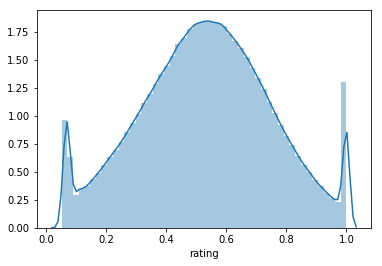

In [127]:
#classic hagia sophia distribution
sns.distplot(p[p.rating!=0].rating)

In [128]:
p[p.rating!=0].shape

(3285246, 4)

- 3.3 million ratings
- 10.8 thousand items
- 8.8 thousand users

# Surprise Time

In [136]:
reader = Reader()
data = Dataset.load_from_df(p[p.rating!=0][['user', 'game', 'rating']], reader)

### Cell below takes 8 minutes to run

In [147]:
start = time()
algo = SVD()
trainset = data.build_full_trainset()
algo.fit(trainset)
print(time()-start)

490.28220891952515


In [142]:
help(algo.fit)

Help on cython_function_or_method in module surprise.prediction_algorithms.matrix_factorization:

fit(self, trainset)



<center>
$ \hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u $
</center>

In [140]:
help(SVD)

Help on class SVD in module surprise.prediction_algorithms.matrix_factorization:

class SVD(surprise.prediction_algorithms.algo_base.AlgoBase)
 |  The famous *SVD* algorithm, as popularized by `Simon Funk
 |  <http://sifter.org/~simon/journal/20061211.html>`_ during the Netflix
 |  Prize. When baselines are not used, this is equivalent to Probabilistic
 |  Matrix Factorization :cite:`salakhutdinov2008a` (see :ref:`note
 |  <unbiased_note>` below).
 |  
 |  The prediction :math:`\hat{r}_{ui}` is set as:
 |  
 |  .. math::
 |      \hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u
 |  
 |  If user :math:`u` is unknown, then the bias :math:`b_u` and the factors
 |  :math:`p_u` are assumed to be zero. The same applies for item :math:`i`
 |  with :math:`b_i` and :math:`q_i`.
 |  
 |  For details, see equation (5) from :cite:`Koren:2009`. See also
 |  :cite:`Ricci:2010`, section 5.3.1.
 |  
 |  To estimate all the unknown, we minimize the following regularized squared
 |  error:
 |  
 |  .. math::
 |